In [ ]:
# Загружаем модули
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D, concatenate, Embedding, multiply
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import LeakyReLU
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
# Подключаем Гугл диск
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
# MNIST
batch_size = 128
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

In [ ]:
# MNIST Size
img_rows_mnist = 28
img_cols_mnist = 28
channels_mnist = 1
img_shape_mnist = (img_rows_mnist, img_cols_mnist, channels_mnist)
latent_dim = 100
batch_size_mnist = 128

In [ ]:
def get_optimizer():
  return Adam(learning_rate = 0.0002, beta_1 = 0.5)

In [ ]:
def create_generator_mnist():
  generator = Sequential()

  generator.add(Dense(256, input_dim = latent_dim))
  generator.add(LeakyReLU(alpha = 0.2))
  generator.add(BatchNormalization(momentum = 0.8))

  generator.add(Dense(512))
  generator.add(LeakyReLU(alpha = 0.2))
  generator.add(BatchNormalization(momentum = 0.8))

  generator.add(Dense(1024))
  generator.add(LeakyReLU(alpha = 0.2))
  generator.add(BatchNormalization(momentum = 0.8))

  generator.add(Dense(np.prod(img_shape_mnist), activation='tanh'))
  generator.add(Reshape(img_shape_mnist))

  noise = Input(shape=(latent_dim,))
  img = generator(noise)
  generator = Model(noise, img)
  return generator

In [ ]:
generator_mnist = create_generator_mnist()
generator_mnist.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         1493520   
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


In [ ]:
def create_discriminator_mnist():
  dis = Sequential()

  dis.add(Conv2D(4, (3, 3), padding = 'same', input_shape = img_shape_mnist))
  dis.add(LeakyReLU(alpha = 0.2))
  dis.add(Flatten())
  dis.add(Dense(512))
  dis.add(LeakyReLU(alpha = 0.2))
  dis.add(Dense(1, activation='sigmoid'))

  img = Input(shape=img_shape_mnist)
  validity = dis(img)
  discriminator_mnist = Model(img, validity)
  discriminator_mnist.compile(loss = 'binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
  discriminator_mnist.trainable = False
  return discriminator_mnist

In [ ]:
discriminator_mnist = create_discriminator_mnist()
discriminator_mnist.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1606697   
Total params: 1,606,697
Trainable params: 0
Non-trainable params: 1,606,697
_________________________________________________________________


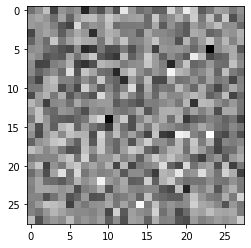

In [ ]:
input1 = np.random.random(size=(1, 100))
plt.imshow(input1, cmap='gray')
plt.axis('off')
plt.show()
predict_gen = generator_mnist.predict(input1)
plt.imshow(predict_gen[0].reshape(28, 28), cmap='gray')
plt.show()

In [ ]:
# Функция печати изображений
def get_images(epoch, gen, noise):
  r,c = 5, 5
  gen_img = generator_mnist.predict(noise)
  fig, axs = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(gen_img[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  plt.show()
  fig.savefig('images/%d.png' % epoch)
  plt.close()

In [ ]:
# Функция обучения 
def train(generator, discriminator, epochs=30000, batch_size=128): 

  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))
  r, c = 5, 5
  z = Input(shape=(latent_dim,))
  img = generator_mnist(z)
  validity = discriminator_mnist(img)

  combined = Model(z, validity)
  combined.compile(loss = 'binary_crossentropy', optimizer = get_optimizer())

  sample_interval = 100

  d_loss_list = []
  g_loss_list = []
  d_acc_list = []

  CONST_NOISE = np.random.normal(0, 1, (r * c, latent_dim))
  # Train Discriminator
  for epoch in range(epochs):

    idx = np.random.choice(X_train.shape[0], batch_size, replace = False)
    imgs = X_train[idx]
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator_mnist.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid) 
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    g_loss = combined.train_on_batch(noise, valid)
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    d_loss_list.append(d_loss[0])
    g_loss_list.append(g_loss)
    d_acc_list.append(100 * d_loss[1])

    if ((epoch % sample_interval == 0) | (epoch == epoch-1)):
      get_images(epoch, generator_mnist, CONST_NOISE)

  plt.plot(d_loss_list, label="Ошибка дискриминатора")
  plt.plot(g_loss_list, label="Ошибка генератора")
  plt.legend()
  plt.show()
  plt.plot(d_acc_list, label="Точность распознавания дискриминатора")
  plt.legend()
  plt.show()

0 [D loss: 0.287682, acc.: 92.19%] [G loss: 2.717674]


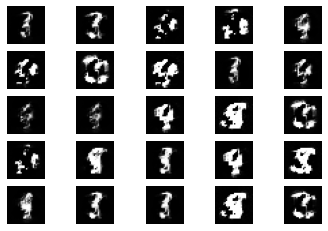

1 [D loss: 0.248950, acc.: 94.53%] [G loss: 2.730194]
2 [D loss: 0.312819, acc.: 91.80%] [G loss: 2.574582]
3 [D loss: 0.253151, acc.: 93.36%] [G loss: 2.704792]
4 [D loss: 0.304203, acc.: 90.62%] [G loss: 2.511570]
5 [D loss: 0.240103, acc.: 96.09%] [G loss: 2.768116]
6 [D loss: 0.327095, acc.: 89.45%] [G loss: 2.582244]
7 [D loss: 0.351782, acc.: 84.38%] [G loss: 2.548707]
8 [D loss: 0.220936, acc.: 94.14%] [G loss: 2.896827]
9 [D loss: 0.361031, acc.: 87.11%] [G loss: 2.508870]
10 [D loss: 0.302862, acc.: 91.02%] [G loss: 2.645460]
11 [D loss: 0.270169, acc.: 89.84%] [G loss: 2.817587]
12 [D loss: 0.420779, acc.: 84.38%] [G loss: 2.280769]
13 [D loss: 0.355576, acc.: 86.33%] [G loss: 2.798182]
14 [D loss: 0.279663, acc.: 91.41%] [G loss: 2.772486]
15 [D loss: 0.238875, acc.: 94.53%] [G loss: 2.741613]
16 [D loss: 0.241691, acc.: 94.53%] [G loss: 2.631062]
17 [D loss: 0.299048, acc.: 90.62%] [G loss: 2.638798]
18 [D loss: 0.347673, acc.: 87.11%] [G loss: 2.563470]
19 [D loss: 0.24775

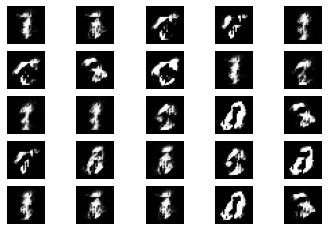

101 [D loss: 0.473449, acc.: 76.95%] [G loss: 2.469617]
102 [D loss: 0.317335, acc.: 89.06%] [G loss: 2.724426]
103 [D loss: 0.463361, acc.: 81.64%] [G loss: 2.376372]
104 [D loss: 0.479135, acc.: 83.98%] [G loss: 2.542740]
105 [D loss: 0.343283, acc.: 89.45%] [G loss: 2.448042]
106 [D loss: 0.364277, acc.: 86.72%] [G loss: 2.395938]
107 [D loss: 0.378736, acc.: 87.11%] [G loss: 2.372669]
108 [D loss: 0.368234, acc.: 85.16%] [G loss: 2.597978]
109 [D loss: 0.405956, acc.: 84.77%] [G loss: 2.303524]
110 [D loss: 0.354229, acc.: 85.55%] [G loss: 2.476981]
111 [D loss: 0.284408, acc.: 91.02%] [G loss: 2.679963]
112 [D loss: 0.441303, acc.: 80.08%] [G loss: 2.413296]
113 [D loss: 0.398679, acc.: 84.77%] [G loss: 2.364026]
114 [D loss: 0.409813, acc.: 84.77%] [G loss: 2.470812]
115 [D loss: 0.461975, acc.: 81.25%] [G loss: 2.387805]
116 [D loss: 0.456217, acc.: 78.52%] [G loss: 2.325164]
117 [D loss: 0.383063, acc.: 87.89%] [G loss: 2.507463]
118 [D loss: 0.361066, acc.: 88.28%] [G loss: 2.

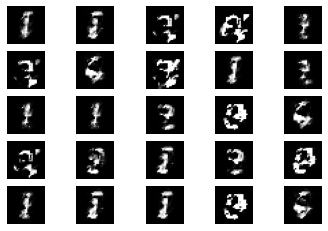

201 [D loss: 0.278045, acc.: 91.41%] [G loss: 2.541458]
202 [D loss: 0.321408, acc.: 89.84%] [G loss: 2.645679]
203 [D loss: 0.276948, acc.: 90.62%] [G loss: 2.662661]
204 [D loss: 0.513911, acc.: 72.27%] [G loss: 2.310306]
205 [D loss: 0.259371, acc.: 91.80%] [G loss: 2.791257]
206 [D loss: 0.375561, acc.: 87.50%] [G loss: 2.436825]
207 [D loss: 0.338760, acc.: 86.72%] [G loss: 2.546903]
208 [D loss: 0.337119, acc.: 90.62%] [G loss: 2.467258]
209 [D loss: 0.345292, acc.: 88.28%] [G loss: 2.484921]
210 [D loss: 0.355492, acc.: 87.50%] [G loss: 2.530757]
211 [D loss: 0.321334, acc.: 88.67%] [G loss: 2.660444]
212 [D loss: 0.390384, acc.: 87.50%] [G loss: 2.484215]
213 [D loss: 0.346041, acc.: 86.72%] [G loss: 2.481245]
214 [D loss: 0.276467, acc.: 89.45%] [G loss: 2.637616]
215 [D loss: 0.328299, acc.: 88.67%] [G loss: 2.562626]
216 [D loss: 0.332155, acc.: 89.45%] [G loss: 2.573192]
217 [D loss: 0.388702, acc.: 85.16%] [G loss: 2.414881]
218 [D loss: 0.468290, acc.: 81.64%] [G loss: 2.

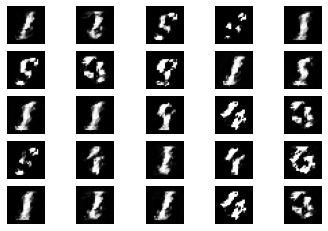

301 [D loss: 0.367948, acc.: 86.72%] [G loss: 2.518624]
302 [D loss: 0.489149, acc.: 80.47%] [G loss: 2.219032]
303 [D loss: 0.408625, acc.: 86.33%] [G loss: 2.345967]
304 [D loss: 0.404483, acc.: 87.89%] [G loss: 2.251424]
305 [D loss: 0.502892, acc.: 76.56%] [G loss: 2.273977]
306 [D loss: 0.361893, acc.: 87.50%] [G loss: 2.563887]
307 [D loss: 0.478384, acc.: 81.25%] [G loss: 2.228961]
308 [D loss: 0.484428, acc.: 80.47%] [G loss: 2.242024]
309 [D loss: 0.508336, acc.: 76.17%] [G loss: 2.306822]
310 [D loss: 0.487278, acc.: 76.95%] [G loss: 2.310377]
311 [D loss: 0.441495, acc.: 82.81%] [G loss: 2.324763]
312 [D loss: 0.408816, acc.: 85.16%] [G loss: 2.276577]
313 [D loss: 0.552753, acc.: 74.61%] [G loss: 2.312289]
314 [D loss: 0.467673, acc.: 82.42%] [G loss: 2.331478]
315 [D loss: 0.444269, acc.: 81.64%] [G loss: 2.254502]
316 [D loss: 0.410135, acc.: 82.03%] [G loss: 2.303899]
317 [D loss: 0.513716, acc.: 76.95%] [G loss: 2.176703]
318 [D loss: 0.466327, acc.: 81.64%] [G loss: 2.

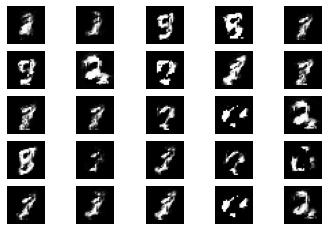

401 [D loss: 0.337590, acc.: 87.89%] [G loss: 2.251410]
402 [D loss: 0.437139, acc.: 80.86%] [G loss: 2.278583]
403 [D loss: 0.406026, acc.: 87.89%] [G loss: 2.197620]
404 [D loss: 0.370686, acc.: 88.67%] [G loss: 2.127915]
405 [D loss: 0.346894, acc.: 89.84%] [G loss: 2.245736]
406 [D loss: 0.344547, acc.: 89.84%] [G loss: 2.173340]
407 [D loss: 0.421239, acc.: 82.81%] [G loss: 2.154250]
408 [D loss: 0.378408, acc.: 86.72%] [G loss: 2.131007]
409 [D loss: 0.412001, acc.: 84.77%] [G loss: 2.130753]
410 [D loss: 0.425826, acc.: 86.33%] [G loss: 2.091751]
411 [D loss: 0.399450, acc.: 87.89%] [G loss: 2.087829]
412 [D loss: 0.449229, acc.: 83.59%] [G loss: 2.073261]
413 [D loss: 0.431611, acc.: 84.77%] [G loss: 2.024411]
414 [D loss: 0.420685, acc.: 85.94%] [G loss: 2.102684]
415 [D loss: 0.375766, acc.: 85.94%] [G loss: 2.194534]
416 [D loss: 0.408311, acc.: 85.16%] [G loss: 2.035625]
417 [D loss: 0.391252, acc.: 84.38%] [G loss: 2.141487]
418 [D loss: 0.361345, acc.: 87.89%] [G loss: 2.

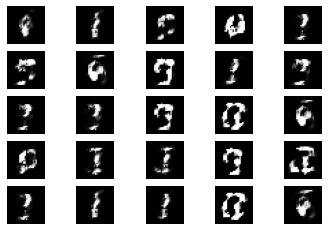

501 [D loss: 0.429699, acc.: 84.38%] [G loss: 2.116778]
502 [D loss: 0.412890, acc.: 85.94%] [G loss: 2.228209]
503 [D loss: 0.434869, acc.: 83.98%] [G loss: 2.064988]
504 [D loss: 0.500752, acc.: 79.69%] [G loss: 2.048174]
505 [D loss: 0.367241, acc.: 86.33%] [G loss: 2.437738]
506 [D loss: 0.450230, acc.: 83.59%] [G loss: 2.190552]
507 [D loss: 0.495543, acc.: 77.73%] [G loss: 2.117118]
508 [D loss: 0.462984, acc.: 79.30%] [G loss: 2.357305]
509 [D loss: 0.489799, acc.: 78.91%] [G loss: 2.184207]
510 [D loss: 0.411735, acc.: 84.77%] [G loss: 2.224506]
511 [D loss: 0.425746, acc.: 83.59%] [G loss: 2.159003]
512 [D loss: 0.418799, acc.: 84.77%] [G loss: 2.270593]
513 [D loss: 0.470036, acc.: 82.81%] [G loss: 2.107707]
514 [D loss: 0.396956, acc.: 83.98%] [G loss: 2.237264]
515 [D loss: 0.373544, acc.: 89.06%] [G loss: 2.202234]
516 [D loss: 0.421818, acc.: 84.77%] [G loss: 2.142097]
517 [D loss: 0.335923, acc.: 87.11%] [G loss: 2.251458]
518 [D loss: 0.402750, acc.: 88.28%] [G loss: 2.

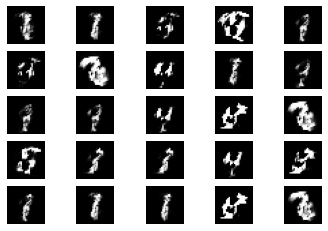

601 [D loss: 0.267694, acc.: 91.02%] [G loss: 2.502532]
602 [D loss: 0.254816, acc.: 95.31%] [G loss: 2.520029]
603 [D loss: 0.365049, acc.: 84.38%] [G loss: 2.348293]
604 [D loss: 0.257202, acc.: 92.58%] [G loss: 2.491252]
605 [D loss: 0.301325, acc.: 90.62%] [G loss: 2.426786]
606 [D loss: 0.302367, acc.: 90.62%] [G loss: 2.419681]
607 [D loss: 0.298392, acc.: 89.45%] [G loss: 2.491293]
608 [D loss: 0.343405, acc.: 88.67%] [G loss: 2.330078]
609 [D loss: 0.256031, acc.: 92.19%] [G loss: 2.495699]
610 [D loss: 0.271220, acc.: 93.36%] [G loss: 2.347216]
611 [D loss: 0.340183, acc.: 90.23%] [G loss: 2.158099]
612 [D loss: 0.310173, acc.: 91.41%] [G loss: 2.342837]
613 [D loss: 0.314455, acc.: 89.06%] [G loss: 2.483500]
614 [D loss: 0.280923, acc.: 90.62%] [G loss: 2.389622]
615 [D loss: 0.372902, acc.: 85.94%] [G loss: 2.146272]
616 [D loss: 0.284618, acc.: 89.84%] [G loss: 2.412326]
617 [D loss: 0.407101, acc.: 87.50%] [G loss: 2.230232]
618 [D loss: 0.376662, acc.: 87.11%] [G loss: 2.

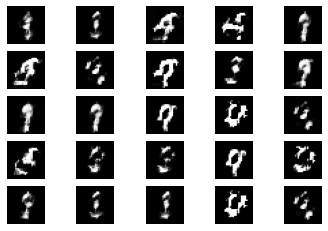

701 [D loss: 0.367028, acc.: 87.89%] [G loss: 2.244554]
702 [D loss: 0.363018, acc.: 86.72%] [G loss: 2.318536]
703 [D loss: 0.370636, acc.: 88.28%] [G loss: 2.218022]
704 [D loss: 0.343058, acc.: 88.28%] [G loss: 2.260484]
705 [D loss: 0.364109, acc.: 87.11%] [G loss: 2.198446]
706 [D loss: 0.384376, acc.: 87.11%] [G loss: 2.261253]
707 [D loss: 0.373824, acc.: 85.94%] [G loss: 2.250349]
708 [D loss: 0.347824, acc.: 86.72%] [G loss: 2.297254]
709 [D loss: 0.366317, acc.: 87.50%] [G loss: 2.103955]
710 [D loss: 0.386057, acc.: 86.72%] [G loss: 2.198987]
711 [D loss: 0.349048, acc.: 87.11%] [G loss: 2.346054]
712 [D loss: 0.387761, acc.: 87.11%] [G loss: 2.183553]
713 [D loss: 0.317083, acc.: 90.62%] [G loss: 2.292079]
714 [D loss: 0.334077, acc.: 85.94%] [G loss: 2.397295]
715 [D loss: 0.305894, acc.: 89.06%] [G loss: 2.281571]
716 [D loss: 0.453323, acc.: 82.42%] [G loss: 2.121182]
717 [D loss: 0.378993, acc.: 83.98%] [G loss: 2.170885]
718 [D loss: 0.468360, acc.: 80.08%] [G loss: 2.

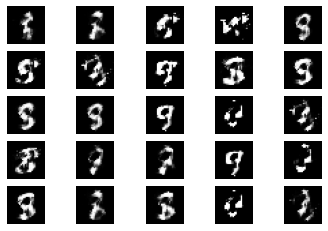

801 [D loss: 0.301058, acc.: 89.45%] [G loss: 2.405316]
802 [D loss: 0.395407, acc.: 86.72%] [G loss: 2.293524]
803 [D loss: 0.355112, acc.: 89.06%] [G loss: 2.228852]
804 [D loss: 0.363262, acc.: 85.55%] [G loss: 2.357998]
805 [D loss: 0.439768, acc.: 81.25%] [G loss: 2.174925]
806 [D loss: 0.315928, acc.: 91.41%] [G loss: 2.327840]
807 [D loss: 0.432054, acc.: 85.16%] [G loss: 2.155719]
808 [D loss: 0.393255, acc.: 85.16%] [G loss: 2.289068]
809 [D loss: 0.443624, acc.: 81.25%] [G loss: 2.223051]
810 [D loss: 0.442531, acc.: 84.77%] [G loss: 2.145396]
811 [D loss: 0.427594, acc.: 87.50%] [G loss: 2.191847]
812 [D loss: 0.458333, acc.: 87.11%] [G loss: 2.109028]
813 [D loss: 0.451747, acc.: 82.42%] [G loss: 2.130478]
814 [D loss: 0.375943, acc.: 87.50%] [G loss: 2.258482]
815 [D loss: 0.413063, acc.: 87.50%] [G loss: 2.123391]
816 [D loss: 0.379622, acc.: 85.94%] [G loss: 2.140900]
817 [D loss: 0.429862, acc.: 85.55%] [G loss: 2.151381]
818 [D loss: 0.416972, acc.: 83.59%] [G loss: 2.

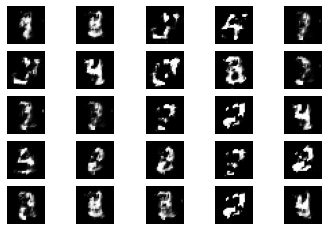

901 [D loss: 0.313251, acc.: 90.23%] [G loss: 2.259053]
902 [D loss: 0.341362, acc.: 89.06%] [G loss: 2.217347]
903 [D loss: 0.412501, acc.: 85.16%] [G loss: 2.110394]
904 [D loss: 0.381664, acc.: 86.33%] [G loss: 2.179267]
905 [D loss: 0.395998, acc.: 85.55%] [G loss: 2.229935]
906 [D loss: 0.283180, acc.: 91.80%] [G loss: 2.320768]
907 [D loss: 0.391133, acc.: 85.16%] [G loss: 2.224013]
908 [D loss: 0.329395, acc.: 91.02%] [G loss: 2.193819]
909 [D loss: 0.372376, acc.: 85.94%] [G loss: 2.166900]
910 [D loss: 0.298346, acc.: 90.62%] [G loss: 2.337282]
911 [D loss: 0.407088, acc.: 85.55%] [G loss: 2.179288]
912 [D loss: 0.380838, acc.: 87.89%] [G loss: 2.203289]
913 [D loss: 0.377742, acc.: 88.67%] [G loss: 2.309841]
914 [D loss: 0.354318, acc.: 88.28%] [G loss: 2.217865]
915 [D loss: 0.409216, acc.: 83.20%] [G loss: 2.246085]
916 [D loss: 0.315606, acc.: 90.23%] [G loss: 2.330253]
917 [D loss: 0.375296, acc.: 86.33%] [G loss: 2.266311]
918 [D loss: 0.399870, acc.: 83.20%] [G loss: 2.

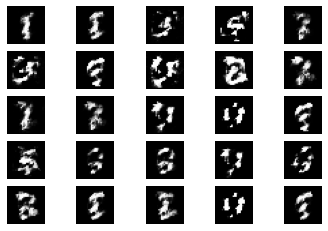

1001 [D loss: 0.367814, acc.: 86.33%] [G loss: 2.437160]
1002 [D loss: 0.385665, acc.: 85.55%] [G loss: 2.375389]
1003 [D loss: 0.398672, acc.: 83.59%] [G loss: 2.331622]
1004 [D loss: 0.401684, acc.: 83.98%] [G loss: 2.273760]
1005 [D loss: 0.423843, acc.: 82.42%] [G loss: 2.328527]
1006 [D loss: 0.337841, acc.: 89.06%] [G loss: 2.507394]
1007 [D loss: 0.418531, acc.: 82.81%] [G loss: 2.406654]
1008 [D loss: 0.436714, acc.: 84.77%] [G loss: 2.250664]
1009 [D loss: 0.450095, acc.: 76.95%] [G loss: 2.276239]
1010 [D loss: 0.385665, acc.: 85.94%] [G loss: 2.309323]
1011 [D loss: 0.368711, acc.: 88.28%] [G loss: 2.374640]
1012 [D loss: 0.403826, acc.: 85.94%] [G loss: 2.277366]
1013 [D loss: 0.392230, acc.: 85.94%] [G loss: 2.246347]
1014 [D loss: 0.355954, acc.: 88.67%] [G loss: 2.363581]
1015 [D loss: 0.238365, acc.: 92.58%] [G loss: 2.506388]
1016 [D loss: 0.265732, acc.: 93.36%] [G loss: 2.435545]
1017 [D loss: 0.336078, acc.: 89.06%] [G loss: 2.300457]
1018 [D loss: 0.397209, acc.: 8

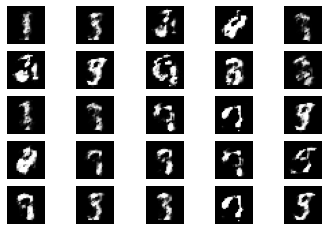

1101 [D loss: 0.394848, acc.: 85.16%] [G loss: 2.113911]
1102 [D loss: 0.495531, acc.: 80.47%] [G loss: 1.995264]
1103 [D loss: 0.395265, acc.: 85.16%] [G loss: 2.048187]
1104 [D loss: 0.361554, acc.: 86.33%] [G loss: 2.165013]
1105 [D loss: 0.445823, acc.: 83.20%] [G loss: 1.958560]
1106 [D loss: 0.338616, acc.: 89.84%] [G loss: 2.153241]
1107 [D loss: 0.413563, acc.: 85.55%] [G loss: 2.121972]
1108 [D loss: 0.484833, acc.: 76.95%] [G loss: 2.057569]
1109 [D loss: 0.363942, acc.: 87.89%] [G loss: 2.219909]
1110 [D loss: 0.480827, acc.: 81.25%] [G loss: 1.990135]
1111 [D loss: 0.366398, acc.: 89.06%] [G loss: 2.059740]
1112 [D loss: 0.377284, acc.: 86.72%] [G loss: 2.168585]
1113 [D loss: 0.413110, acc.: 83.98%] [G loss: 2.046664]
1114 [D loss: 0.365788, acc.: 85.94%] [G loss: 2.333557]
1115 [D loss: 0.434133, acc.: 83.59%] [G loss: 2.029395]
1116 [D loss: 0.375945, acc.: 89.06%] [G loss: 2.054507]
1117 [D loss: 0.338647, acc.: 90.62%] [G loss: 2.165445]
1118 [D loss: 0.305585, acc.: 9

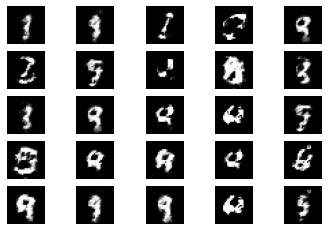

1201 [D loss: 0.388984, acc.: 86.33%] [G loss: 2.300462]
1202 [D loss: 0.405811, acc.: 83.20%] [G loss: 2.185987]
1203 [D loss: 0.415440, acc.: 83.98%] [G loss: 2.304006]
1204 [D loss: 0.364496, acc.: 88.67%] [G loss: 2.254686]
1205 [D loss: 0.422914, acc.: 83.98%] [G loss: 2.133159]
1206 [D loss: 0.379484, acc.: 84.77%] [G loss: 2.256272]
1207 [D loss: 0.419713, acc.: 82.42%] [G loss: 2.233338]
1208 [D loss: 0.398628, acc.: 83.98%] [G loss: 2.131542]
1209 [D loss: 0.432512, acc.: 80.47%] [G loss: 2.188849]
1210 [D loss: 0.416616, acc.: 80.47%] [G loss: 2.287490]
1211 [D loss: 0.362984, acc.: 87.89%] [G loss: 2.310169]
1212 [D loss: 0.443029, acc.: 80.47%] [G loss: 2.193499]
1213 [D loss: 0.357644, acc.: 87.11%] [G loss: 2.316947]
1214 [D loss: 0.447304, acc.: 80.86%] [G loss: 2.135247]
1215 [D loss: 0.370511, acc.: 84.38%] [G loss: 2.287222]
1216 [D loss: 0.492116, acc.: 77.73%] [G loss: 2.149174]
1217 [D loss: 0.394722, acc.: 83.20%] [G loss: 2.292864]
1218 [D loss: 0.451245, acc.: 8

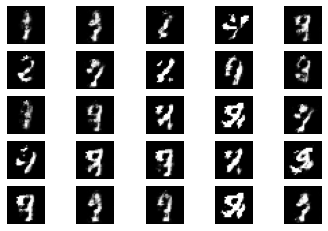

1301 [D loss: 0.459581, acc.: 76.95%] [G loss: 2.305562]
1302 [D loss: 0.414985, acc.: 83.59%] [G loss: 2.188352]
1303 [D loss: 0.364418, acc.: 87.11%] [G loss: 2.190342]
1304 [D loss: 0.373898, acc.: 85.55%] [G loss: 2.174829]
1305 [D loss: 0.366963, acc.: 85.94%] [G loss: 2.285674]
1306 [D loss: 0.410594, acc.: 83.20%] [G loss: 2.092908]
1307 [D loss: 0.311412, acc.: 91.02%] [G loss: 2.223002]
1308 [D loss: 0.342095, acc.: 86.72%] [G loss: 2.095753]
1309 [D loss: 0.383207, acc.: 87.11%] [G loss: 2.305840]
1310 [D loss: 0.342523, acc.: 89.84%] [G loss: 2.256451]
1311 [D loss: 0.373941, acc.: 88.67%] [G loss: 2.126276]
1312 [D loss: 0.350126, acc.: 91.41%] [G loss: 2.205989]
1313 [D loss: 0.321722, acc.: 91.02%] [G loss: 2.273477]
1314 [D loss: 0.339152, acc.: 89.45%] [G loss: 2.140337]
1315 [D loss: 0.354649, acc.: 86.72%] [G loss: 2.112664]
1316 [D loss: 0.350770, acc.: 87.11%] [G loss: 2.413356]
1317 [D loss: 0.412284, acc.: 83.59%] [G loss: 2.147629]
1318 [D loss: 0.333393, acc.: 8

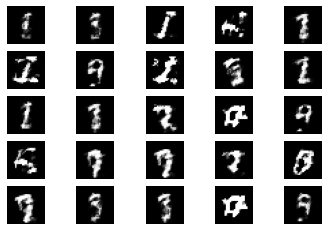

1401 [D loss: 0.352791, acc.: 88.67%] [G loss: 2.242995]
1402 [D loss: 0.321901, acc.: 89.84%] [G loss: 2.341738]
1403 [D loss: 0.352260, acc.: 89.06%] [G loss: 2.255828]
1404 [D loss: 0.316268, acc.: 89.45%] [G loss: 2.280321]
1405 [D loss: 0.288090, acc.: 91.80%] [G loss: 2.301627]
1406 [D loss: 0.324769, acc.: 88.67%] [G loss: 2.336209]
1407 [D loss: 0.284398, acc.: 90.23%] [G loss: 2.332919]
1408 [D loss: 0.395473, acc.: 83.59%] [G loss: 2.164687]
1409 [D loss: 0.324585, acc.: 89.84%] [G loss: 2.241066]
1410 [D loss: 0.334983, acc.: 87.89%] [G loss: 2.310714]
1411 [D loss: 0.336289, acc.: 89.06%] [G loss: 2.311272]
1412 [D loss: 0.324714, acc.: 90.62%] [G loss: 2.368610]
1413 [D loss: 0.370694, acc.: 87.11%] [G loss: 2.199315]
1414 [D loss: 0.360928, acc.: 86.72%] [G loss: 2.217263]
1415 [D loss: 0.349152, acc.: 87.50%] [G loss: 2.321660]
1416 [D loss: 0.388794, acc.: 82.81%] [G loss: 2.351930]
1417 [D loss: 0.443802, acc.: 81.64%] [G loss: 2.255152]
1418 [D loss: 0.401250, acc.: 8

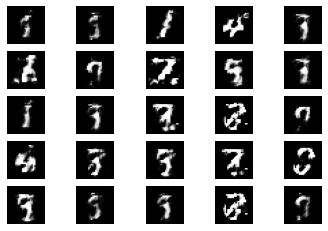

1501 [D loss: 0.423724, acc.: 83.98%] [G loss: 2.242310]
1502 [D loss: 0.333462, acc.: 89.06%] [G loss: 2.365397]
1503 [D loss: 0.396415, acc.: 84.38%] [G loss: 2.179794]
1504 [D loss: 0.481574, acc.: 81.64%] [G loss: 2.110930]
1505 [D loss: 0.351105, acc.: 87.89%] [G loss: 2.253653]
1506 [D loss: 0.419861, acc.: 83.59%] [G loss: 2.192380]
1507 [D loss: 0.323121, acc.: 88.67%] [G loss: 2.363368]
1508 [D loss: 0.483842, acc.: 76.56%] [G loss: 2.103972]
1509 [D loss: 0.337239, acc.: 88.28%] [G loss: 2.318331]
1510 [D loss: 0.410939, acc.: 80.86%] [G loss: 2.211871]
1511 [D loss: 0.364458, acc.: 87.89%] [G loss: 2.227245]
1512 [D loss: 0.371350, acc.: 85.94%] [G loss: 2.229370]
1513 [D loss: 0.322947, acc.: 88.67%] [G loss: 2.315149]
1514 [D loss: 0.372494, acc.: 84.77%] [G loss: 2.180911]
1515 [D loss: 0.384348, acc.: 87.11%] [G loss: 2.154027]
1516 [D loss: 0.345974, acc.: 86.72%] [G loss: 2.357943]
1517 [D loss: 0.376397, acc.: 83.98%] [G loss: 2.196105]
1518 [D loss: 0.408615, acc.: 8

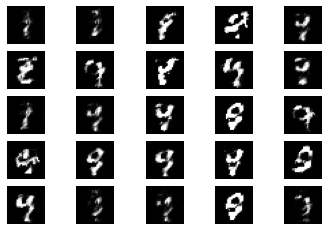

1601 [D loss: 0.451816, acc.: 80.47%] [G loss: 2.051114]
1602 [D loss: 0.420354, acc.: 81.64%] [G loss: 2.130146]
1603 [D loss: 0.416731, acc.: 79.30%] [G loss: 2.420034]
1604 [D loss: 0.398139, acc.: 84.38%] [G loss: 2.142116]
1605 [D loss: 0.320904, acc.: 91.02%] [G loss: 2.292028]
1606 [D loss: 0.309713, acc.: 87.50%] [G loss: 2.311075]
1607 [D loss: 0.339994, acc.: 89.06%] [G loss: 2.193918]
1608 [D loss: 0.397706, acc.: 84.77%] [G loss: 2.127544]
1609 [D loss: 0.279185, acc.: 92.19%] [G loss: 2.321620]
1610 [D loss: 0.378830, acc.: 86.33%] [G loss: 2.295032]
1611 [D loss: 0.375746, acc.: 86.72%] [G loss: 2.208483]
1612 [D loss: 0.333985, acc.: 87.89%] [G loss: 2.277076]
1613 [D loss: 0.438761, acc.: 81.25%] [G loss: 2.300321]
1614 [D loss: 0.339824, acc.: 88.67%] [G loss: 2.308491]
1615 [D loss: 0.347995, acc.: 86.33%] [G loss: 2.261854]
1616 [D loss: 0.430498, acc.: 80.86%] [G loss: 2.180800]
1617 [D loss: 0.339596, acc.: 87.50%] [G loss: 2.320906]
1618 [D loss: 0.307911, acc.: 8

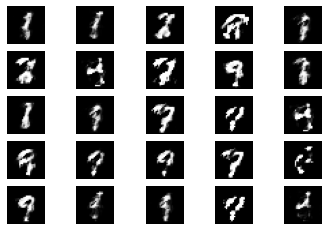

1701 [D loss: 0.348379, acc.: 90.23%] [G loss: 2.269822]
1702 [D loss: 0.372669, acc.: 85.55%] [G loss: 2.173151]
1703 [D loss: 0.406521, acc.: 82.81%] [G loss: 2.119972]
1704 [D loss: 0.359520, acc.: 86.72%] [G loss: 2.240829]
1705 [D loss: 0.371870, acc.: 85.94%] [G loss: 2.157770]
1706 [D loss: 0.340071, acc.: 89.45%] [G loss: 2.176507]
1707 [D loss: 0.341842, acc.: 89.06%] [G loss: 2.109377]
1708 [D loss: 0.368597, acc.: 87.89%] [G loss: 2.150604]
1709 [D loss: 0.347678, acc.: 89.45%] [G loss: 2.142933]
1710 [D loss: 0.361596, acc.: 86.72%] [G loss: 2.192162]
1711 [D loss: 0.400487, acc.: 84.77%] [G loss: 2.126072]
1712 [D loss: 0.365458, acc.: 86.33%] [G loss: 2.157905]
1713 [D loss: 0.362290, acc.: 85.16%] [G loss: 2.156281]
1714 [D loss: 0.382946, acc.: 87.11%] [G loss: 2.079417]
1715 [D loss: 0.394141, acc.: 82.81%] [G loss: 2.179842]
1716 [D loss: 0.417990, acc.: 85.16%] [G loss: 2.077685]
1717 [D loss: 0.413484, acc.: 78.12%] [G loss: 2.120761]
1718 [D loss: 0.317565, acc.: 8

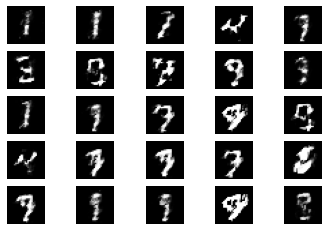

1801 [D loss: 0.360376, acc.: 86.72%] [G loss: 2.248275]
1802 [D loss: 0.308689, acc.: 90.62%] [G loss: 2.313882]
1803 [D loss: 0.362983, acc.: 85.94%] [G loss: 2.165590]
1804 [D loss: 0.350488, acc.: 85.94%] [G loss: 2.110369]
1805 [D loss: 0.370021, acc.: 85.16%] [G loss: 2.295239]
1806 [D loss: 0.408765, acc.: 83.20%] [G loss: 2.090946]
1807 [D loss: 0.324518, acc.: 86.33%] [G loss: 2.309277]
1808 [D loss: 0.466203, acc.: 78.12%] [G loss: 2.061427]
1809 [D loss: 0.397844, acc.: 82.42%] [G loss: 2.216954]
1810 [D loss: 0.408608, acc.: 82.03%] [G loss: 2.201091]
1811 [D loss: 0.351363, acc.: 85.55%] [G loss: 2.249698]
1812 [D loss: 0.398701, acc.: 83.59%] [G loss: 2.205563]
1813 [D loss: 0.394350, acc.: 82.42%] [G loss: 2.273220]
1814 [D loss: 0.472432, acc.: 76.95%] [G loss: 2.117036]
1815 [D loss: 0.449548, acc.: 77.34%] [G loss: 2.189673]
1816 [D loss: 0.397996, acc.: 84.38%] [G loss: 2.158199]
1817 [D loss: 0.425429, acc.: 80.86%] [G loss: 2.251567]
1818 [D loss: 0.383794, acc.: 8

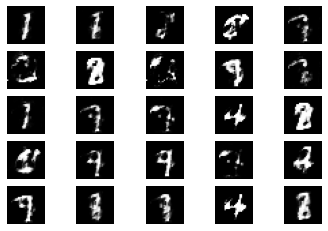

1901 [D loss: 0.367466, acc.: 86.72%] [G loss: 2.292602]
1902 [D loss: 0.396382, acc.: 83.98%] [G loss: 2.082110]
1903 [D loss: 0.440587, acc.: 82.42%] [G loss: 2.167169]
1904 [D loss: 0.387558, acc.: 87.50%] [G loss: 2.194588]
1905 [D loss: 0.373868, acc.: 87.11%] [G loss: 2.223020]
1906 [D loss: 0.340734, acc.: 89.45%] [G loss: 2.231601]
1907 [D loss: 0.437835, acc.: 82.42%] [G loss: 2.080401]
1908 [D loss: 0.437453, acc.: 82.42%] [G loss: 2.233493]
1909 [D loss: 0.470114, acc.: 82.42%] [G loss: 2.050059]
1910 [D loss: 0.366003, acc.: 86.33%] [G loss: 2.441322]
1911 [D loss: 0.461294, acc.: 79.69%] [G loss: 2.118314]
1912 [D loss: 0.345952, acc.: 87.89%] [G loss: 2.377090]
1913 [D loss: 0.394930, acc.: 83.98%] [G loss: 2.234122]
1914 [D loss: 0.472665, acc.: 79.30%] [G loss: 2.071496]
1915 [D loss: 0.399448, acc.: 84.38%] [G loss: 2.212551]
1916 [D loss: 0.296320, acc.: 92.19%] [G loss: 2.316751]
1917 [D loss: 0.480916, acc.: 78.12%] [G loss: 2.200853]
1918 [D loss: 0.415417, acc.: 8

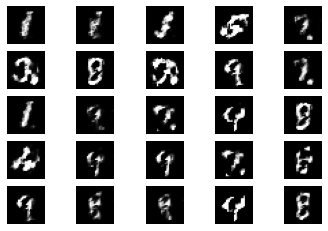

2001 [D loss: 0.379282, acc.: 84.38%] [G loss: 2.234419]
2002 [D loss: 0.418791, acc.: 81.25%] [G loss: 2.166325]
2003 [D loss: 0.393445, acc.: 84.77%] [G loss: 2.299523]
2004 [D loss: 0.395219, acc.: 85.94%] [G loss: 2.235638]
2005 [D loss: 0.366970, acc.: 87.11%] [G loss: 2.201643]
2006 [D loss: 0.502182, acc.: 77.34%] [G loss: 2.026942]
2007 [D loss: 0.387602, acc.: 88.67%] [G loss: 2.270779]
2008 [D loss: 0.355618, acc.: 88.28%] [G loss: 2.181842]
2009 [D loss: 0.426061, acc.: 83.20%] [G loss: 2.044017]
2010 [D loss: 0.380430, acc.: 85.94%] [G loss: 2.221207]
2011 [D loss: 0.378532, acc.: 86.72%] [G loss: 2.307646]
2012 [D loss: 0.394225, acc.: 81.64%] [G loss: 2.169638]
2013 [D loss: 0.465439, acc.: 77.73%] [G loss: 2.115823]
2014 [D loss: 0.297956, acc.: 91.02%] [G loss: 2.353127]
2015 [D loss: 0.401568, acc.: 83.98%] [G loss: 2.165210]
2016 [D loss: 0.415818, acc.: 84.77%] [G loss: 2.097781]
2017 [D loss: 0.425820, acc.: 82.42%] [G loss: 2.214853]
2018 [D loss: 0.324152, acc.: 8

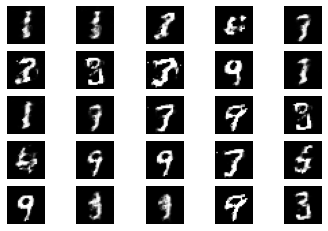

2101 [D loss: 0.472801, acc.: 77.34%] [G loss: 2.087961]
2102 [D loss: 0.436387, acc.: 79.69%] [G loss: 2.137295]
2103 [D loss: 0.584815, acc.: 68.36%] [G loss: 1.991106]
2104 [D loss: 0.526530, acc.: 71.48%] [G loss: 2.094826]
2105 [D loss: 0.464768, acc.: 77.73%] [G loss: 2.087739]
2106 [D loss: 0.486004, acc.: 77.73%] [G loss: 2.048228]
2107 [D loss: 0.396785, acc.: 83.20%] [G loss: 2.205847]
2108 [D loss: 0.521248, acc.: 75.78%] [G loss: 2.096674]
2109 [D loss: 0.520538, acc.: 76.56%] [G loss: 2.082069]
2110 [D loss: 0.475179, acc.: 78.52%] [G loss: 1.994020]
2111 [D loss: 0.528807, acc.: 73.83%] [G loss: 2.053244]
2112 [D loss: 0.401202, acc.: 84.38%] [G loss: 2.277803]
2113 [D loss: 0.484096, acc.: 79.69%] [G loss: 1.951352]
2114 [D loss: 0.456879, acc.: 80.08%] [G loss: 2.074228]
2115 [D loss: 0.355643, acc.: 85.55%] [G loss: 2.244952]
2116 [D loss: 0.412118, acc.: 82.81%] [G loss: 2.101219]
2117 [D loss: 0.501668, acc.: 77.34%] [G loss: 2.058884]
2118 [D loss: 0.356704, acc.: 8

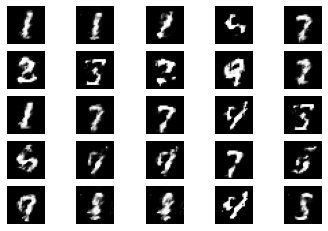

2201 [D loss: 0.396457, acc.: 83.20%] [G loss: 2.113201]
2202 [D loss: 0.311425, acc.: 89.45%] [G loss: 2.356565]
2203 [D loss: 0.363957, acc.: 86.72%] [G loss: 2.186721]
2204 [D loss: 0.387345, acc.: 84.38%] [G loss: 2.119543]
2205 [D loss: 0.318671, acc.: 87.11%] [G loss: 2.327134]
2206 [D loss: 0.306964, acc.: 89.06%] [G loss: 2.314664]
2207 [D loss: 0.343175, acc.: 85.94%] [G loss: 2.206147]
2208 [D loss: 0.310839, acc.: 89.45%] [G loss: 2.321523]
2209 [D loss: 0.343381, acc.: 87.11%] [G loss: 2.172797]
2210 [D loss: 0.378414, acc.: 82.42%] [G loss: 2.095638]
2211 [D loss: 0.379130, acc.: 84.77%] [G loss: 2.159877]
2212 [D loss: 0.318746, acc.: 88.28%] [G loss: 2.270916]
2213 [D loss: 0.439489, acc.: 80.47%] [G loss: 2.088248]
2214 [D loss: 0.411056, acc.: 80.08%] [G loss: 2.222970]
2215 [D loss: 0.455076, acc.: 78.52%] [G loss: 2.074862]
2216 [D loss: 0.421242, acc.: 82.03%] [G loss: 2.108117]
2217 [D loss: 0.445229, acc.: 77.73%] [G loss: 2.128497]
2218 [D loss: 0.417179, acc.: 8

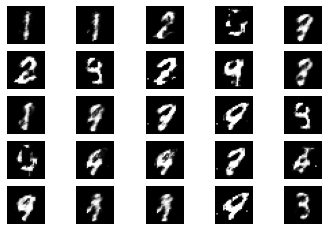

2301 [D loss: 0.424666, acc.: 84.38%] [G loss: 2.077632]
2302 [D loss: 0.467289, acc.: 81.64%] [G loss: 2.064387]
2303 [D loss: 0.490157, acc.: 78.52%] [G loss: 2.048779]
2304 [D loss: 0.460240, acc.: 80.86%] [G loss: 2.146102]
2305 [D loss: 0.307657, acc.: 88.67%] [G loss: 2.346620]
2306 [D loss: 0.474867, acc.: 79.69%] [G loss: 2.042628]
2307 [D loss: 0.381374, acc.: 85.16%] [G loss: 2.245720]
2308 [D loss: 0.441665, acc.: 82.03%] [G loss: 2.048381]
2309 [D loss: 0.349727, acc.: 87.11%] [G loss: 2.194145]
2310 [D loss: 0.392162, acc.: 84.38%] [G loss: 2.159277]
2311 [D loss: 0.314162, acc.: 88.67%] [G loss: 2.240877]
2312 [D loss: 0.459931, acc.: 80.47%] [G loss: 2.079276]
2313 [D loss: 0.264485, acc.: 91.80%] [G loss: 2.393679]
2314 [D loss: 0.377858, acc.: 83.98%] [G loss: 2.116498]
2315 [D loss: 0.403386, acc.: 84.77%] [G loss: 2.127486]
2316 [D loss: 0.344928, acc.: 87.11%] [G loss: 2.252755]
2317 [D loss: 0.402801, acc.: 84.77%] [G loss: 2.234975]
2318 [D loss: 0.340676, acc.: 8

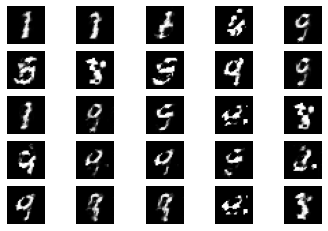

2401 [D loss: 0.238878, acc.: 94.53%] [G loss: 2.404887]
2402 [D loss: 0.304917, acc.: 91.02%] [G loss: 2.272856]
2403 [D loss: 0.314932, acc.: 91.80%] [G loss: 2.325138]
2404 [D loss: 0.326499, acc.: 88.67%] [G loss: 2.278328]
2405 [D loss: 0.254196, acc.: 92.19%] [G loss: 2.375679]
2406 [D loss: 0.333410, acc.: 87.89%] [G loss: 2.238636]
2407 [D loss: 0.324276, acc.: 87.89%] [G loss: 2.290811]
2408 [D loss: 0.306952, acc.: 87.89%] [G loss: 2.228331]
2409 [D loss: 0.297583, acc.: 88.67%] [G loss: 2.202633]
2410 [D loss: 0.339356, acc.: 88.67%] [G loss: 2.273755]
2411 [D loss: 0.270433, acc.: 91.02%] [G loss: 2.435050]
2412 [D loss: 0.430274, acc.: 82.42%] [G loss: 2.124382]
2413 [D loss: 0.373415, acc.: 85.16%] [G loss: 2.195605]
2414 [D loss: 0.341064, acc.: 87.89%] [G loss: 2.241026]
2415 [D loss: 0.339266, acc.: 86.72%] [G loss: 2.315122]
2416 [D loss: 0.325344, acc.: 91.02%] [G loss: 2.123682]
2417 [D loss: 0.351788, acc.: 84.38%] [G loss: 2.188742]
2418 [D loss: 0.336719, acc.: 8

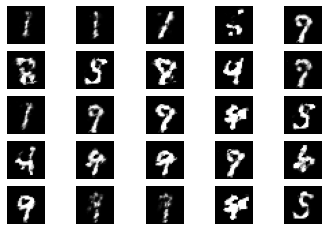

2501 [D loss: 0.444035, acc.: 81.64%] [G loss: 2.055029]
2502 [D loss: 0.399622, acc.: 85.16%] [G loss: 2.301275]
2503 [D loss: 0.445263, acc.: 78.91%] [G loss: 2.199906]
2504 [D loss: 0.402163, acc.: 83.59%] [G loss: 2.164509]
2505 [D loss: 0.468218, acc.: 78.12%] [G loss: 2.005587]
2506 [D loss: 0.439103, acc.: 80.47%] [G loss: 2.148105]
2507 [D loss: 0.471237, acc.: 80.47%] [G loss: 2.046151]
2508 [D loss: 0.400719, acc.: 87.89%] [G loss: 2.121589]
2509 [D loss: 0.394068, acc.: 83.98%] [G loss: 2.151334]
2510 [D loss: 0.455625, acc.: 79.69%] [G loss: 2.059645]
2511 [D loss: 0.459434, acc.: 79.69%] [G loss: 2.182577]
2512 [D loss: 0.414991, acc.: 82.42%] [G loss: 2.190706]
2513 [D loss: 0.393517, acc.: 85.55%] [G loss: 2.312208]
2514 [D loss: 0.432368, acc.: 83.59%] [G loss: 2.065872]
2515 [D loss: 0.464632, acc.: 79.69%] [G loss: 2.088348]
2516 [D loss: 0.458055, acc.: 79.30%] [G loss: 2.179196]
2517 [D loss: 0.387435, acc.: 86.33%] [G loss: 2.204311]
2518 [D loss: 0.439412, acc.: 8

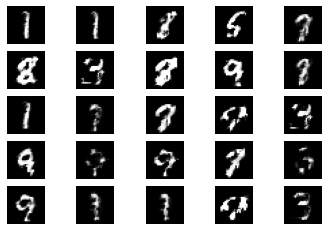

2601 [D loss: 0.423248, acc.: 82.03%] [G loss: 2.104909]
2602 [D loss: 0.356664, acc.: 83.98%] [G loss: 2.084581]
2603 [D loss: 0.416830, acc.: 81.64%] [G loss: 2.044134]
2604 [D loss: 0.327450, acc.: 87.50%] [G loss: 2.334575]
2605 [D loss: 0.421500, acc.: 83.20%] [G loss: 2.029651]
2606 [D loss: 0.457351, acc.: 78.52%] [G loss: 2.011629]
2607 [D loss: 0.397634, acc.: 83.98%] [G loss: 2.050225]
2608 [D loss: 0.363716, acc.: 87.11%] [G loss: 2.103997]
2609 [D loss: 0.471541, acc.: 80.47%] [G loss: 2.210772]
2610 [D loss: 0.382853, acc.: 86.33%] [G loss: 2.104281]
2611 [D loss: 0.483032, acc.: 76.95%] [G loss: 2.119611]
2612 [D loss: 0.369212, acc.: 85.94%] [G loss: 2.119232]
2613 [D loss: 0.426385, acc.: 80.47%] [G loss: 2.057909]
2614 [D loss: 0.381873, acc.: 85.55%] [G loss: 2.172308]
2615 [D loss: 0.544410, acc.: 71.09%] [G loss: 2.055279]
2616 [D loss: 0.430093, acc.: 80.86%] [G loss: 2.112046]
2617 [D loss: 0.403886, acc.: 83.98%] [G loss: 2.065140]
2618 [D loss: 0.390512, acc.: 8

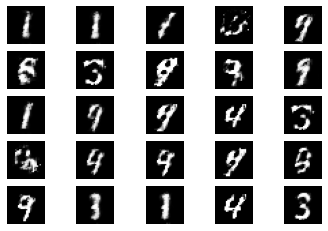

2701 [D loss: 0.324249, acc.: 87.50%] [G loss: 2.249390]
2702 [D loss: 0.406453, acc.: 85.94%] [G loss: 2.031739]
2703 [D loss: 0.410964, acc.: 81.64%] [G loss: 2.055683]
2704 [D loss: 0.394200, acc.: 83.98%] [G loss: 2.084159]
2705 [D loss: 0.403526, acc.: 83.20%] [G loss: 2.076917]
2706 [D loss: 0.468130, acc.: 81.64%] [G loss: 2.006035]
2707 [D loss: 0.462770, acc.: 79.30%] [G loss: 2.007184]
2708 [D loss: 0.458947, acc.: 78.12%] [G loss: 2.065552]
2709 [D loss: 0.378920, acc.: 85.16%] [G loss: 2.196419]
2710 [D loss: 0.437353, acc.: 83.20%] [G loss: 2.084294]
2711 [D loss: 0.417922, acc.: 81.25%] [G loss: 2.124069]
2712 [D loss: 0.447716, acc.: 77.34%] [G loss: 2.068478]
2713 [D loss: 0.539648, acc.: 72.27%] [G loss: 1.931228]
2714 [D loss: 0.429764, acc.: 82.03%] [G loss: 2.156399]
2715 [D loss: 0.467631, acc.: 80.47%] [G loss: 2.064774]
2716 [D loss: 0.449305, acc.: 80.86%] [G loss: 2.030881]
2717 [D loss: 0.406072, acc.: 81.64%] [G loss: 2.163908]
2718 [D loss: 0.443395, acc.: 7

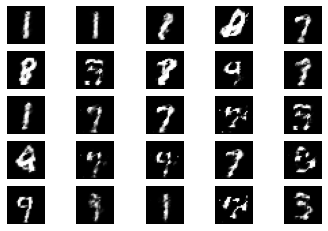

2801 [D loss: 0.450906, acc.: 79.30%] [G loss: 2.057578]
2802 [D loss: 0.445312, acc.: 78.52%] [G loss: 2.014743]
2803 [D loss: 0.478513, acc.: 78.91%] [G loss: 2.065146]
2804 [D loss: 0.415571, acc.: 83.20%] [G loss: 2.146281]
2805 [D loss: 0.383565, acc.: 85.55%] [G loss: 2.187222]
2806 [D loss: 0.481572, acc.: 78.52%] [G loss: 1.942331]
2807 [D loss: 0.396045, acc.: 86.72%] [G loss: 2.134843]
2808 [D loss: 0.443968, acc.: 81.64%] [G loss: 2.137304]
2809 [D loss: 0.492193, acc.: 79.69%] [G loss: 1.938991]
2810 [D loss: 0.423914, acc.: 82.03%] [G loss: 2.066496]
2811 [D loss: 0.406833, acc.: 81.64%] [G loss: 2.135161]
2812 [D loss: 0.499888, acc.: 73.83%] [G loss: 1.936981]
2813 [D loss: 0.413854, acc.: 81.25%] [G loss: 2.023814]
2814 [D loss: 0.419714, acc.: 80.47%] [G loss: 2.101048]
2815 [D loss: 0.499110, acc.: 75.39%] [G loss: 2.030431]
2816 [D loss: 0.446259, acc.: 80.08%] [G loss: 2.120821]
2817 [D loss: 0.454480, acc.: 79.69%] [G loss: 2.077308]
2818 [D loss: 0.441099, acc.: 7

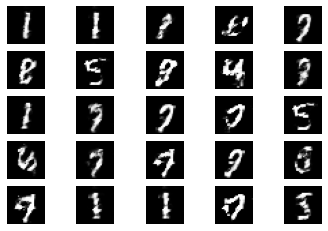

2901 [D loss: 0.408208, acc.: 82.03%] [G loss: 2.107718]
2902 [D loss: 0.383214, acc.: 82.42%] [G loss: 2.100313]
2903 [D loss: 0.443216, acc.: 80.08%] [G loss: 2.048008]
2904 [D loss: 0.380281, acc.: 85.55%] [G loss: 2.129327]
2905 [D loss: 0.322529, acc.: 87.50%] [G loss: 2.152516]
2906 [D loss: 0.454532, acc.: 80.08%] [G loss: 1.994325]
2907 [D loss: 0.406911, acc.: 80.47%] [G loss: 1.865418]
2908 [D loss: 0.428048, acc.: 81.64%] [G loss: 2.035553]
2909 [D loss: 0.367531, acc.: 87.50%] [G loss: 2.216699]
2910 [D loss: 0.353294, acc.: 88.28%] [G loss: 2.202582]
2911 [D loss: 0.408639, acc.: 83.98%] [G loss: 2.044965]
2912 [D loss: 0.473896, acc.: 79.69%] [G loss: 1.887751]
2913 [D loss: 0.393005, acc.: 85.16%] [G loss: 2.046476]
2914 [D loss: 0.402613, acc.: 83.59%] [G loss: 2.171451]
2915 [D loss: 0.441693, acc.: 80.86%] [G loss: 2.103085]
2916 [D loss: 0.500694, acc.: 75.39%] [G loss: 1.997685]
2917 [D loss: 0.508965, acc.: 76.56%] [G loss: 2.014015]
2918 [D loss: 0.461418, acc.: 7

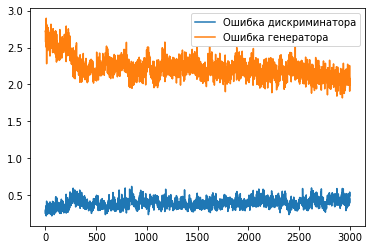

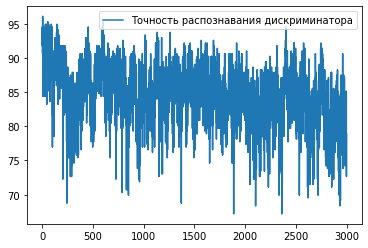

In [ ]:
train(generator_mnist, discriminator_mnist, 3000)